In [1]:
import os
import random
import numpy as np
import pandas as pd
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

train_meta = pd.read_csv(
    '/kaggle/input/isic-2024-challenge/train-metadata.csv',
    low_memory= False
)
test_meta = pd.read_csv(
    '/kaggle/input/isic-2024-challenge/test-metadata.csv',
    low_memory= False
)
common_cols = train_meta.columns.intersection(test_meta.columns).tolist()
train_meta_filtered = train_meta[common_cols]
train_meta_filtered2 = train_meta_filtered
train_meta_filtered2["target"] = train_meta["target"]

print("Filtered training metadata columns:")
print(train_meta_filtered.columns)
train_meta_filtered = train_meta_filtered[test_meta.columns.intersection(common_cols)]
labels = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv',usecols = ['target'])


Filtered training metadata columns:
Index(['isic_id', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license',
       'target'],
      dtype='object')


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
train_meta = train_meta_filtered2


--- Class Distribution (Target Variable) ---
Target Distribution:
target
0    400666
1       393
Name: count, dtype: int64
Target Distribution (%):
target
0    99.902009
1     0.097991
Name: proportion, dtype: float64


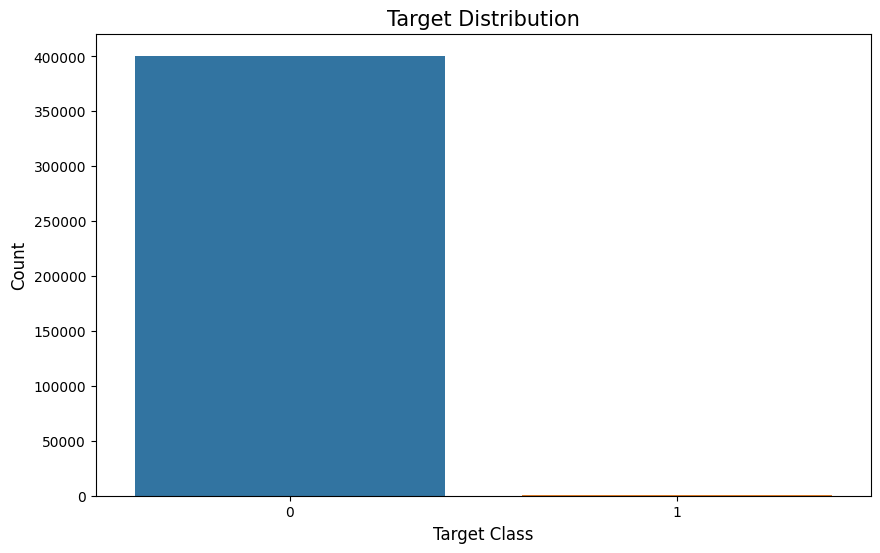

In [3]:
# 1. Check for Data Imbalance
print("\n--- Class Distribution (Target Variable) ---")
if 'target' in train_meta.columns:
    target_dist = train_meta['target'].value_counts(normalize=True) * 100
    print(f"Target Distribution:\n{train_meta['target'].value_counts()}")
    print(f"Target Distribution (%):\n{target_dist}")
    
    # Visualize target distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x='target', data=train_meta)
    plt.title('Target Distribution', fontsize=15)
    plt.xlabel('Target Class', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig('target_distribution.png')
    plt.show()
else:
    print("Target column not found in the dataset.")

In [4]:
print(train_meta_filtered.shape)
labels.shape

(401059, 44)


(401059, 1)

# Missing values

In [5]:
# 2. Missing Values Analysis
import missingno as msno

print("\n--- Missing Values Analysis ---")
missing_train = train_meta.isnull().sum()
print(f"Columns with missing values in train data:\n{missing_train[missing_train > 0]}")
missing_percent_train = (missing_train / len(train_meta)) * 100
print(f"\nPercentage of missing values per column:\n{missing_percent_train[missing_percent_train > 0]}")


--- Missing Values Analysis ---
Columns with missing values in train data:
age_approx              2798
sex                    11517
anatom_site_general     5756
dtype: int64

Percentage of missing values per column:
age_approx             0.697653
sex                    2.871647
anatom_site_general    1.435200
dtype: float64


# Irrelevent Features


--- Correlation Analysis to Find Irrelevant Features ---
Correlation with target variable:
target                         1.000000
tbp_lv_areaMM2                 0.045139
tbp_lv_perimeterMM             0.036188
tbp_lv_minorAxisMM             0.035757
clin_size_long_diam_mm         0.032682
tbp_lv_stdLExt                 0.026084
tbp_lv_radial_color_std_max    0.025441
tbp_lv_color_std_mean          0.024271
tbp_lv_Aext                    0.023206
tbp_lv_norm_color              0.022264
tbp_lv_A                       0.019788
tbp_lv_deltaLBnorm             0.015172
tbp_lv_stdL                    0.012669
tbp_lv_deltaLB                 0.012237
tbp_lv_y                       0.009926
tbp_lv_area_perim_ratio        0.009624
age_approx                     0.007734
tbp_lv_norm_border             0.006747
tbp_lv_symm_2axis              0.002583
tbp_lv_symm_2axis_angle        0.000867
tbp_lv_Lext                   -0.000417
tbp_lv_Cext                   -0.000807
tbp_lv_deltaA               

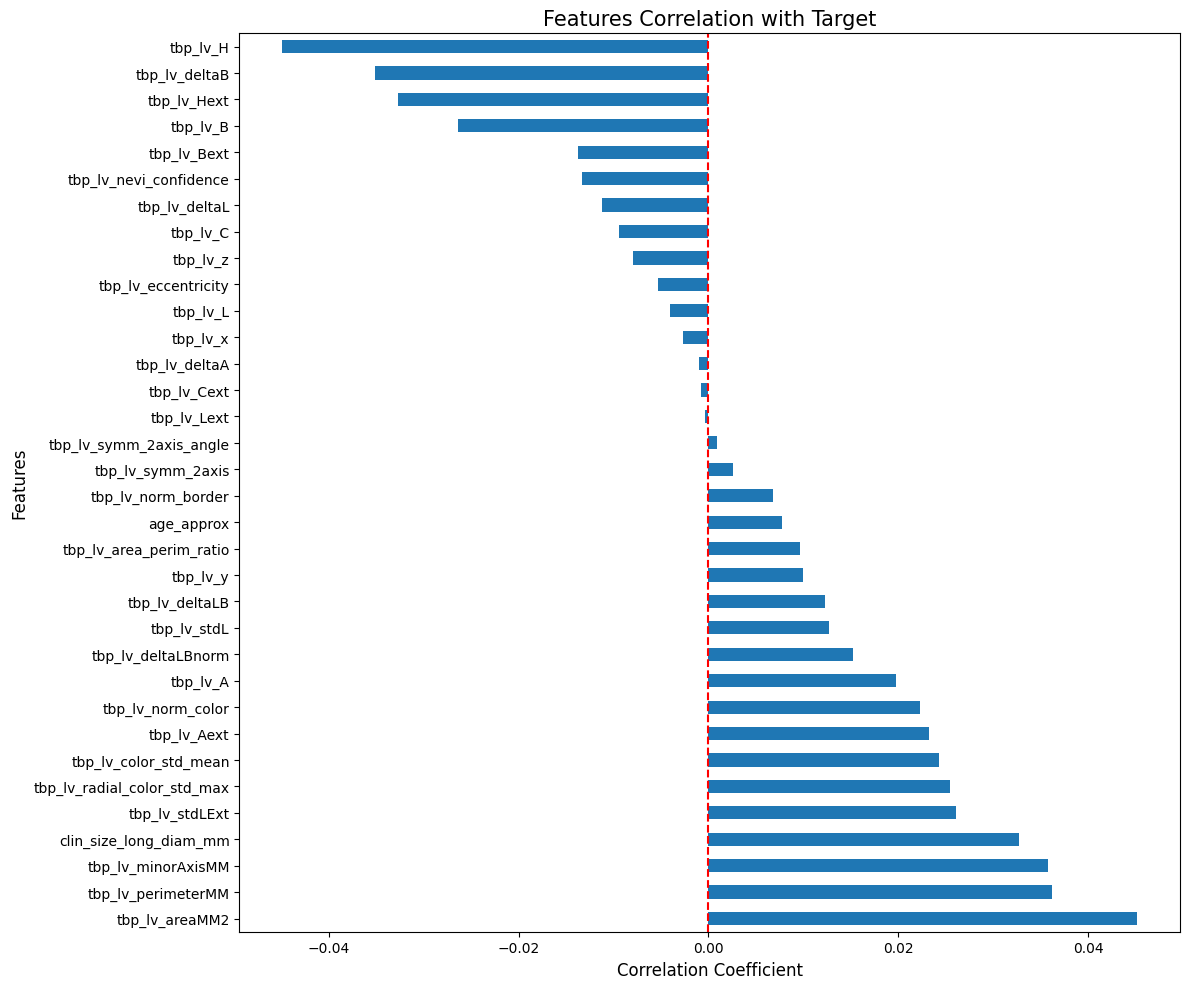

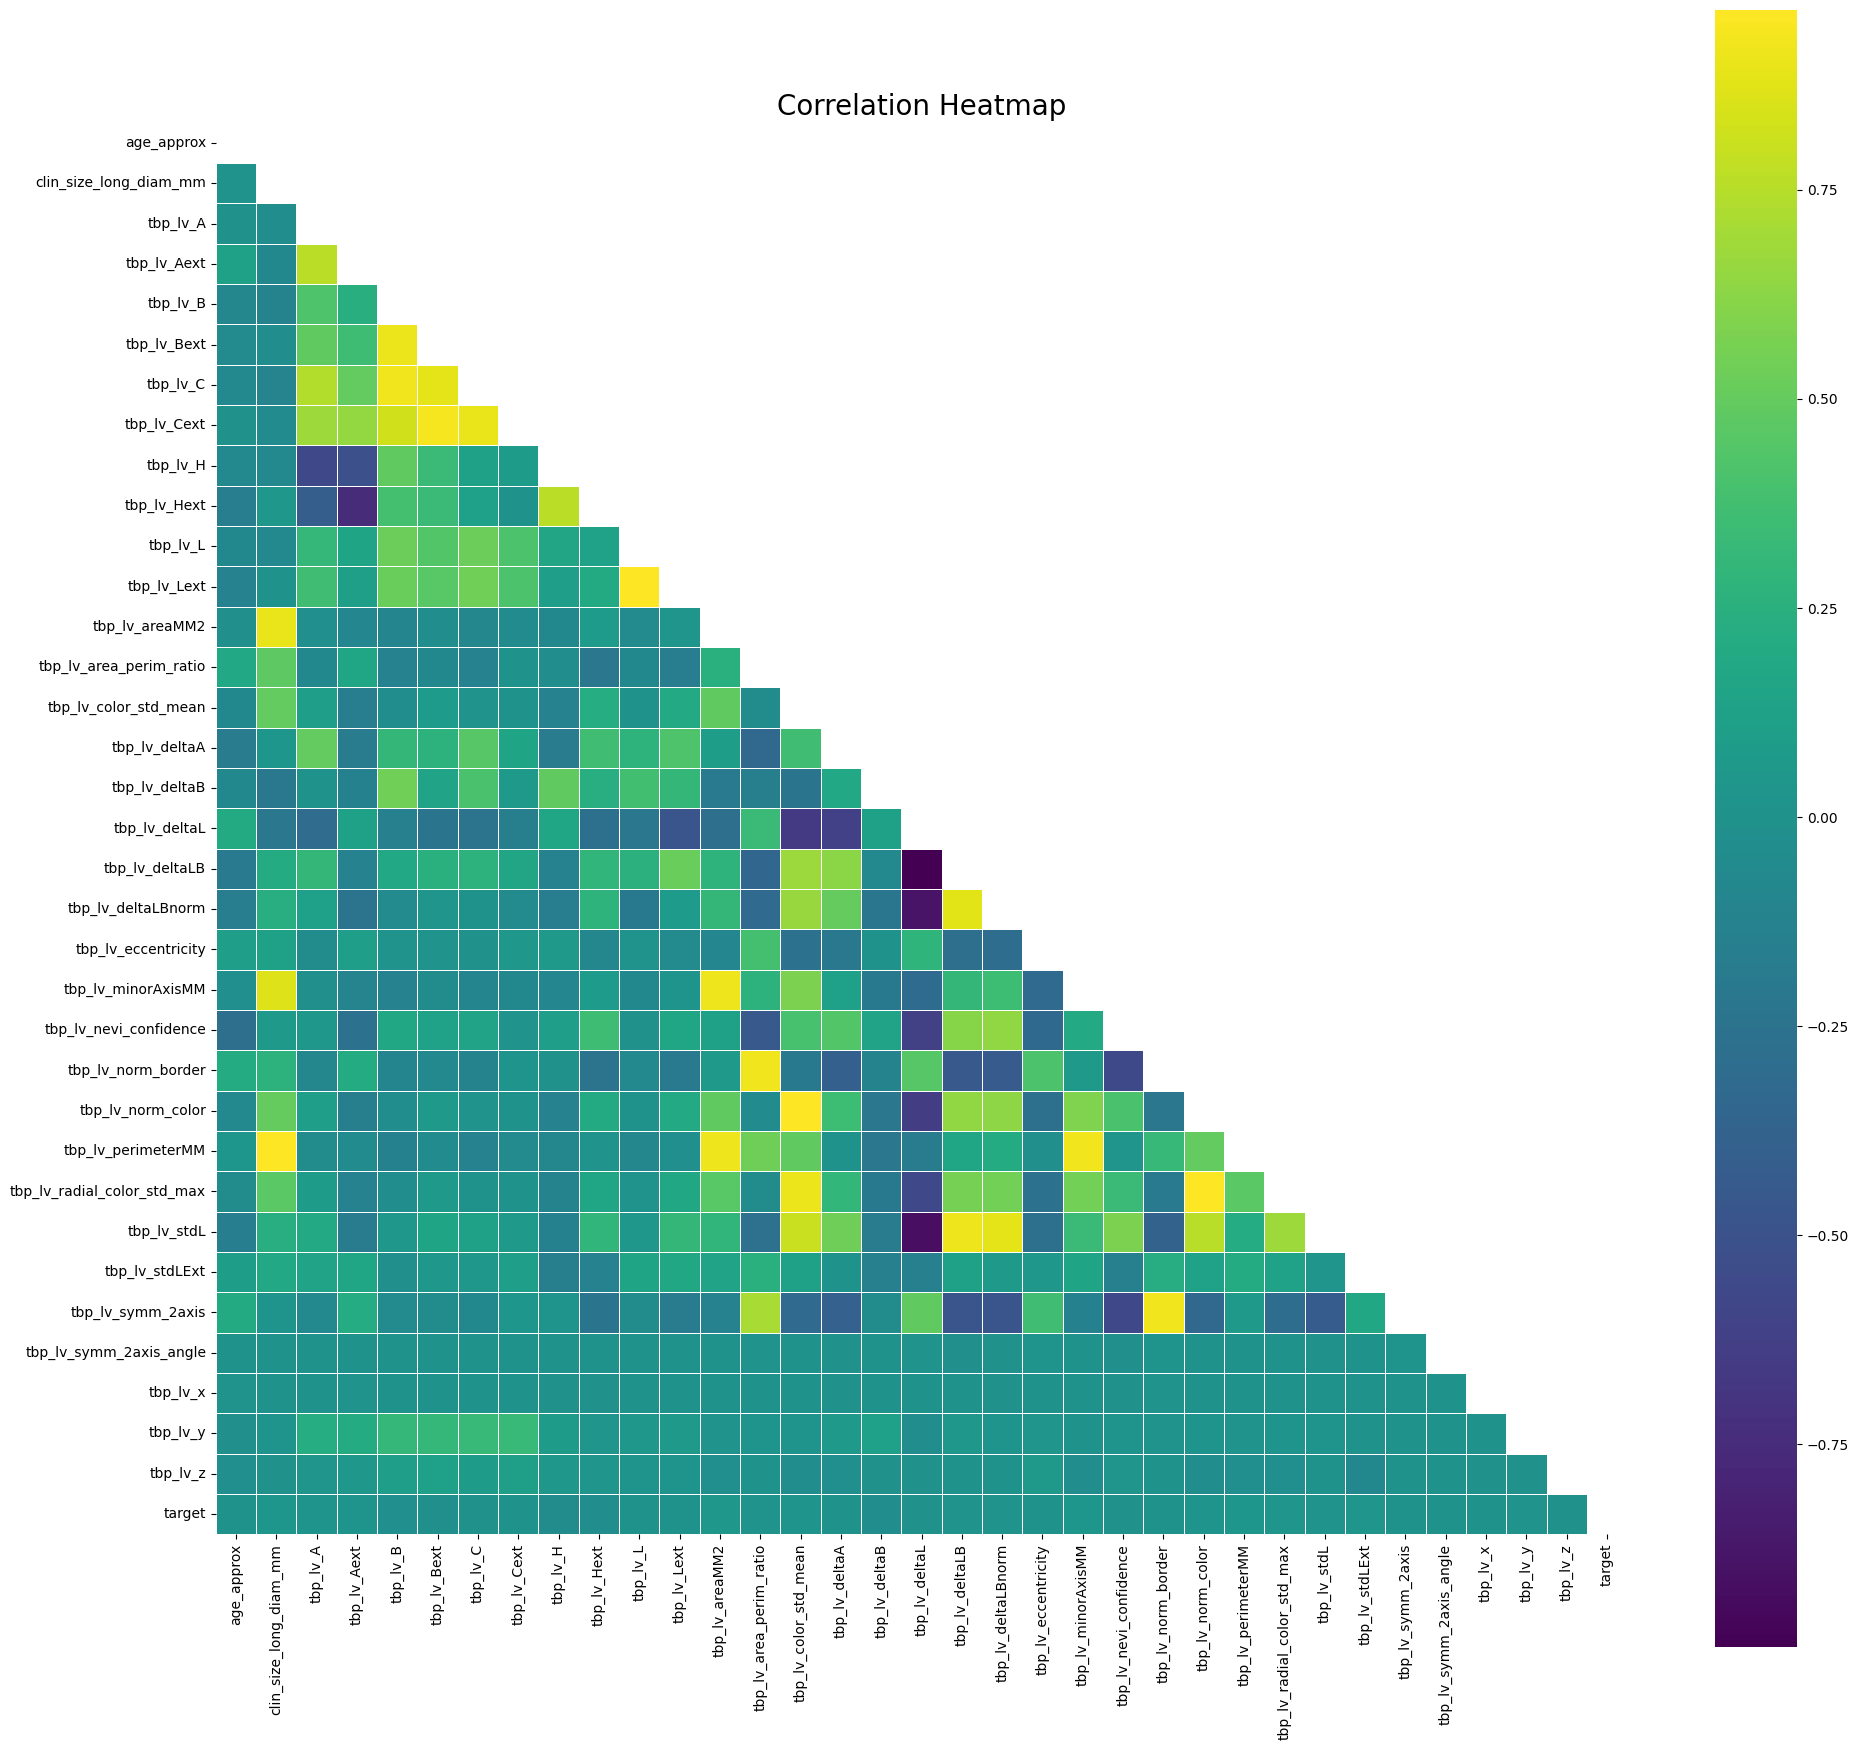

In [6]:
# 3. Irrelevant Data Analysis
print("\n--- Correlation Analysis to Find Irrelevant Features ---")
# Calculate correlation for numeric columns only
numeric_cols = train_meta.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) > 1:
    # Drop target from correlation calculation if it exists
    if 'target' in numeric_cols:
        correlation_with_target = train_meta[numeric_cols].corr()['target'].sort_values(ascending=False)
        print(f"Correlation with target variable:\n{correlation_with_target}")
        
        # Visualize features correlation with target
        plt.figure(figsize=(12, 10))
        correlation_with_target[correlation_with_target.index != 'target'].plot(kind='barh')
        plt.title('Features Correlation with Target', fontsize=15)
        plt.xlabel('Correlation Coefficient', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.axvline(x=0, color='red', linestyle='--')
        plt.tight_layout()
        plt.savefig('features_correlation_with_target.png')
        plt.show()
    
    # Visualize correlation matrix
    plt.figure(figsize=(20, 18))
    corr_matrix = train_meta[numeric_cols].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='viridis', linewidths=.5, fmt='.2f', square=True)
    plt.title('Correlation Heatmap', fontsize=20)
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()
else:
    print("Not enough numeric columns to calculate correlation.")

# Outliers


--- Outlier Analysis ---


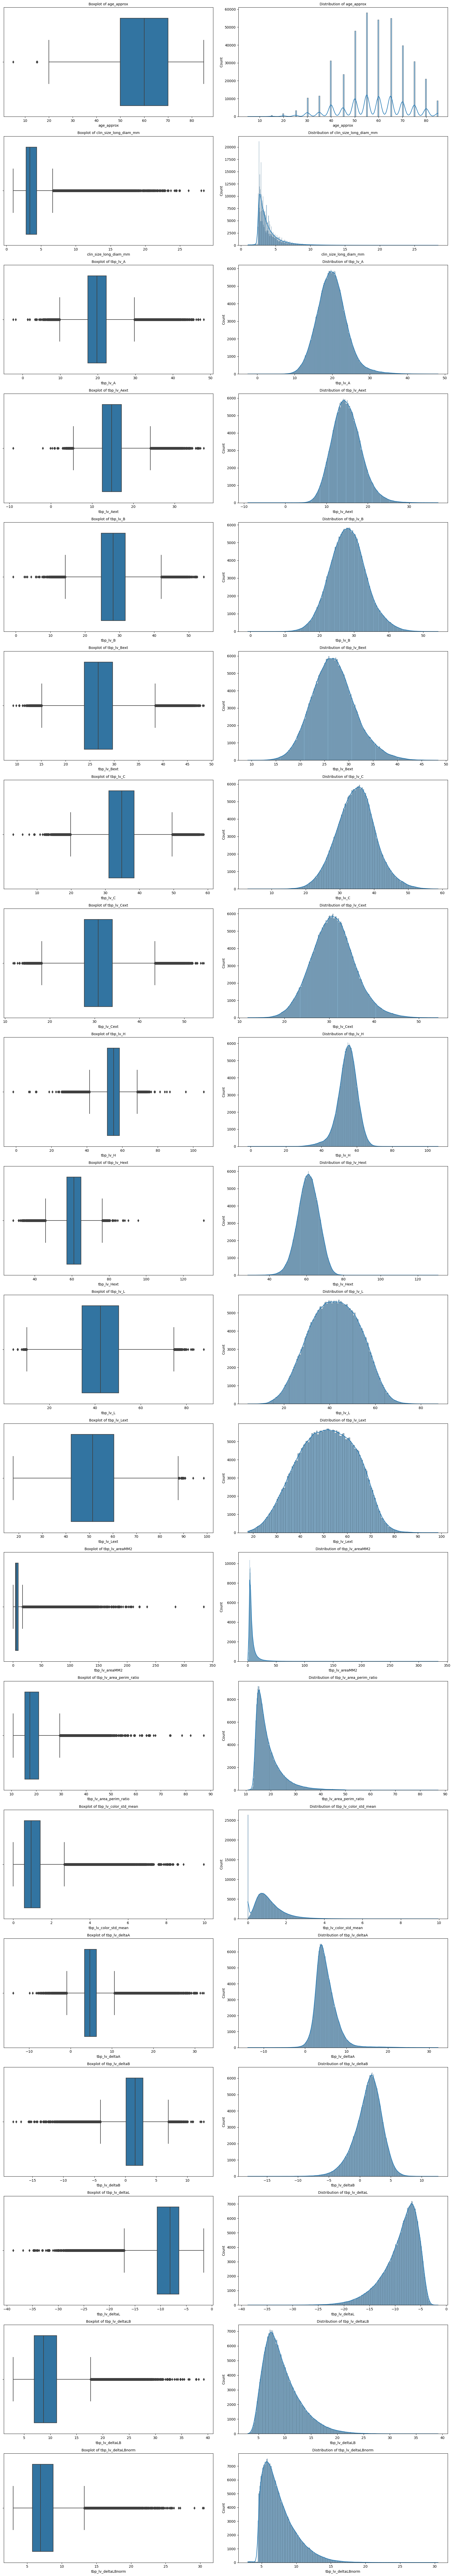


Outliers Summary:
                    Column Total_Outliers  Percentage
0           tbp_lv_areaMM2          36748    9.162742
0   clin_size_long_diam_mm          27365    6.823186
0  tbp_lv_area_perim_ratio          21850    5.448076
0    tbp_lv_color_std_mean          15379    3.834598
0            tbp_lv_deltaA          12415    3.095555
0            tbp_lv_deltaL          11987    2.988837
0       tbp_lv_deltaLBnorm          11975    2.985845
0           tbp_lv_deltaLB          11574    2.885860
0                 tbp_lv_H           9822    2.449016
0            tbp_lv_deltaB           8312    2.072513
0                 tbp_lv_A           8057    2.008931
0              tbp_lv_Bext           5260    1.311528
0              tbp_lv_Cext           4829    1.204062
0                 tbp_lv_C           4766    1.188354
0              tbp_lv_Aext           4723    1.177632
0                 tbp_lv_B           4474    1.115547
0              tbp_lv_Hext           2936    0.732062
0        

In [7]:
#  Outlier Detection
print("\n--- Outlier Analysis ---")
numeric_cols_no_target = [col for col in numeric_cols if col != 'target']
if numeric_cols_no_target:
    # Calculate IQR for each numeric column
    outliers_summary = pd.DataFrame(columns=['Column', 'Total_Outliers', 'Percentage'])
    
    plt.figure(figsize=(18, len(numeric_cols_no_target) * 3))
    for i, col in enumerate(numeric_cols_no_target[:20]):  # Limit to first 20 cols for visualization
        Q1 = train_meta[col].quantile(0.25)
        Q3 = train_meta[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        # Determine outliers
        outliers = train_meta[(train_meta[col] < Q1 - outlier_step) | 
                            (train_meta[col] > Q3 + outlier_step)][col]
        
        # Add to summary
        outliers_summary = pd.concat([outliers_summary, pd.DataFrame({
            'Column': [col],
            'Total_Outliers': [len(outliers)],
            'Percentage': [len(outliers) / len(train_meta) * 100]
        })])
        
        # Boxplot
        plt.subplot(len(numeric_cols_no_target[:20]), 2, 2*i+1)
        sns.boxplot(x=train_meta[col])
        plt.title(f'Boxplot of {col}', fontsize=10)
        plt.tight_layout()
        
        # Distribution
        plt.subplot(len(numeric_cols_no_target[:20]), 2, 2*i+2)
        sns.histplot(train_meta[col], kde=True)
        plt.title(f'Distribution of {col}', fontsize=10)
        plt.tight_layout()
    
    plt.savefig('outliers_distribution.png')
    plt.show()
    
    # Print outliers summary
    print("\nOutliers Summary:")
    print(outliers_summary.sort_values('Percentage', ascending=False))
else:
    print("No numeric columns available for outlier analysis.")

# Skewness and Kurtosis

In [8]:
#  Skewed Distribution and Kurtosis Analysis
print("\n--- Skewness and Kurtosis Analysis ---")
skew_kurt_summary = pd.DataFrame(columns=['Column', 'Skewness', 'Kurtosis'])

for col in numeric_cols_no_target:
    if train_meta[col].nunique() > 1:  
        skewness = train_meta[col].skew()
        kurtosis = train_meta[col].kurt()
        
        skew_kurt_summary = pd.concat([skew_kurt_summary, pd.DataFrame({
            'Column': [col],
            'Skewness': [skewness],
            'Kurtosis': [kurtosis]
        })])

# thresholds
high_skew_threshold = 1.0
high_kurt_threshold = 3.0

print("\nColumns with High Skewness (>1.0):")
print(skew_kurt_summary[skew_kurt_summary['Skewness'].abs() > high_skew_threshold].sort_values('Skewness', ascending=False))

print("\nColumns with High Kurtosis (>3.0):")
print(skew_kurt_summary[skew_kurt_summary['Kurtosis'] > high_kurt_threshold].sort_values('Kurtosis', ascending=False))


--- Skewness and Kurtosis Analysis ---

Columns with High Skewness (>1.0):
                        Column  Skewness   Kurtosis
0               tbp_lv_areaMM2  5.908436  59.082499
0           tbp_lv_perimeterMM  3.123993  15.701203
0       clin_size_long_diam_mm  2.831952  12.528743
0               tbp_lv_stdLExt  2.815049  35.361805
0           tbp_lv_minorAxisMM  2.429612  10.223534
0      tbp_lv_area_perim_ratio  1.982719   5.299625
0                tbp_lv_deltaA  1.808798   8.272006
0  tbp_lv_radial_color_std_max  1.747608   7.164557
0                  tbp_lv_stdL  1.582380   3.060989
0        tbp_lv_color_std_mean  1.573142   4.973169
0           tbp_lv_deltaLBnorm  1.348489   2.462041
0               tbp_lv_deltaLB  1.197946   1.949471
0           tbp_lv_norm_border  1.158386   1.091584
0                tbp_lv_deltaL -1.212669   1.903719

Columns with High Kurtosis (>3.0):
                        Column  Skewness   Kurtosis
0               tbp_lv_areaMM2  5.908436  59.082499
0   

# Inconsistent data


--- Categorical Data Consistency Analysis ---

Unique values in isic_id: 401059
Too many unique values (401059) to display. Top 10:
isic_id
ISIC_0015670    1
ISIC_6699080    1
ISIC_6699647    1
ISIC_6699636    1
ISIC_6699544    1
ISIC_6699513    1
ISIC_6699499    1
ISIC_6699477    1
ISIC_6699464    1
ISIC_6699462    1
Name: count, dtype: int64

Unique values in patient_id: 1042
Too many unique values (1042) to display. Top 10:
patient_id
IP_1117889    9184
IP_5714646    6267
IP_3921915    5568
IP_7797815    4454
IP_9577633    3583
IP_5539318    2859
IP_9853536    2327
IP_5143034    2283
IP_0321326    2245
IP_5426188    2193
Name: count, dtype: int64

Unique values in sex: 2
sex
male      265546
female    123996
Name: count, dtype: int64


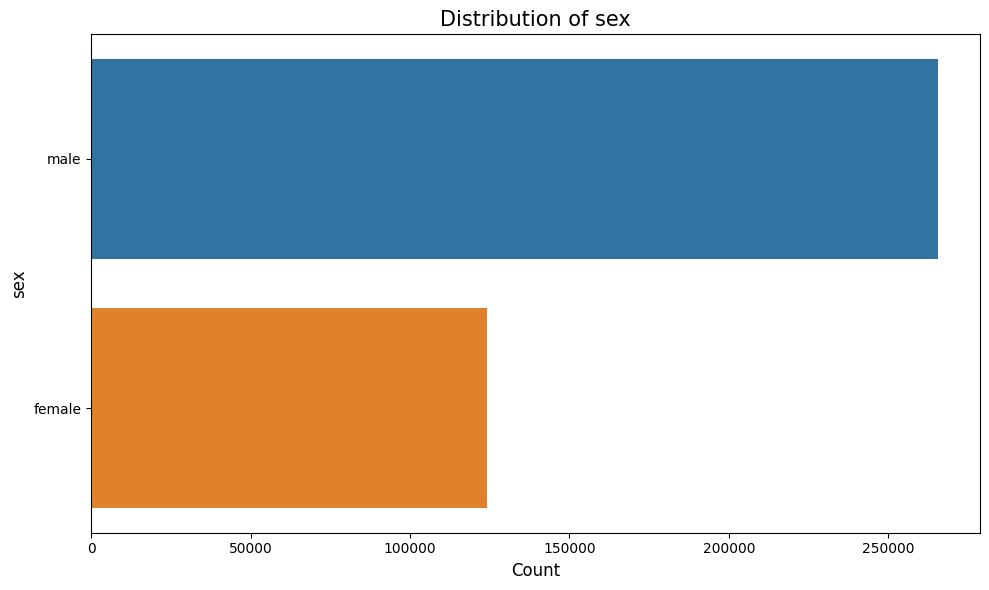


Unique values in anatom_site_general: 5
anatom_site_general
posterior torso    121902
lower extremity    103028
anterior torso      87770
upper extremity     70557
head/neck           12046
Name: count, dtype: int64


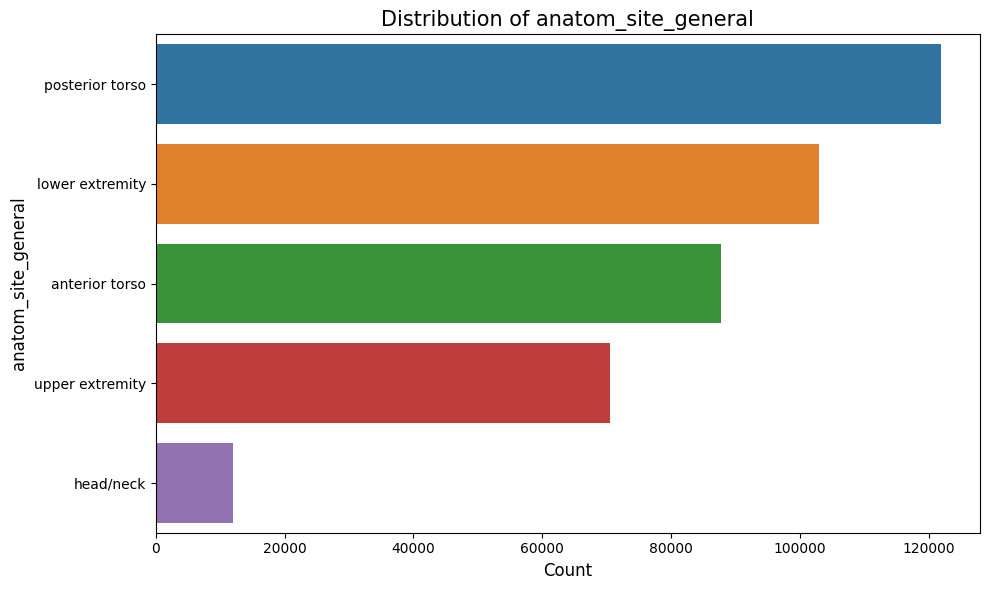


Unique values in image_type: 1
image_type
TBP tile: close-up    401059
Name: count, dtype: int64


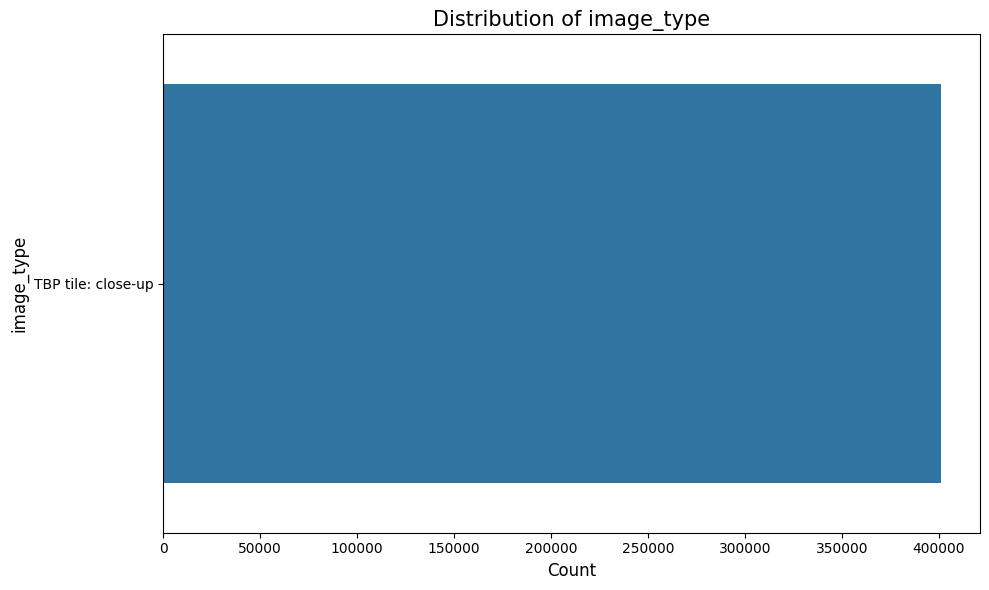


Unique values in tbp_tile_type: 2
tbp_tile_type
3D: XP       285903
3D: white    115156
Name: count, dtype: int64


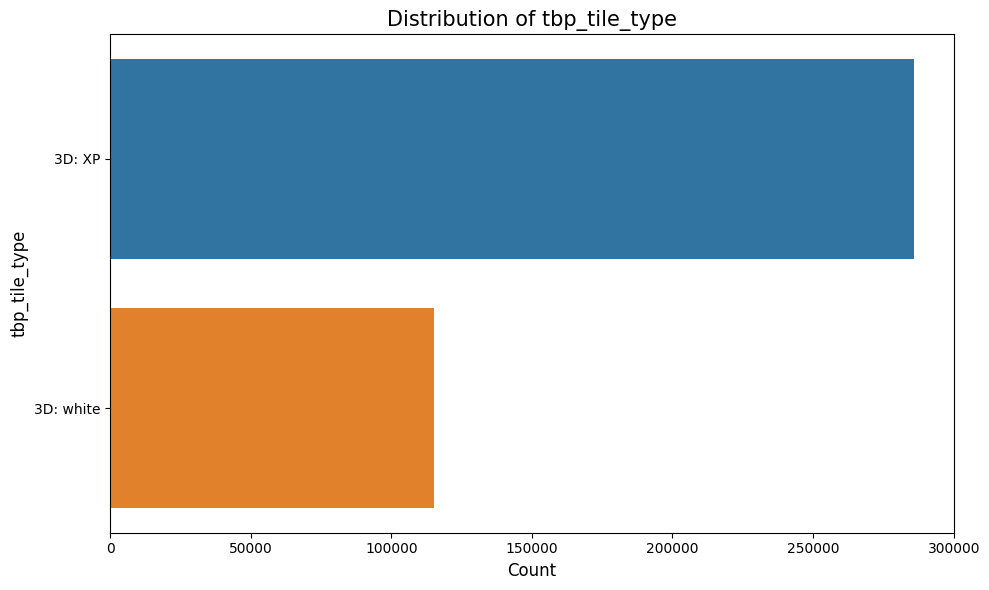


Unique values in tbp_lv_location: 21
Too many unique values (21) to display. Top 10:
tbp_lv_location
Torso Back Top Third       71112
Torso Front Top Half       63350
Torso Back Middle Third    46185
Left Leg - Lower           27428
Right Leg - Lower          25208
Torso Front Bottom Half    24360
Left Leg - Upper           23673
Right Leg - Upper          23034
Right Arm - Upper          22972
Left Arm - Upper           22816
Name: count, dtype: int64

Unique values in tbp_lv_location_simple: 8
tbp_lv_location_simple
Torso Back     121902
Torso Front     87770
Left Leg        53075
Right Leg       49953
Left Arm        36348
Right Arm       34209
Head & Neck     12046
Unknown          5756
Name: count, dtype: int64


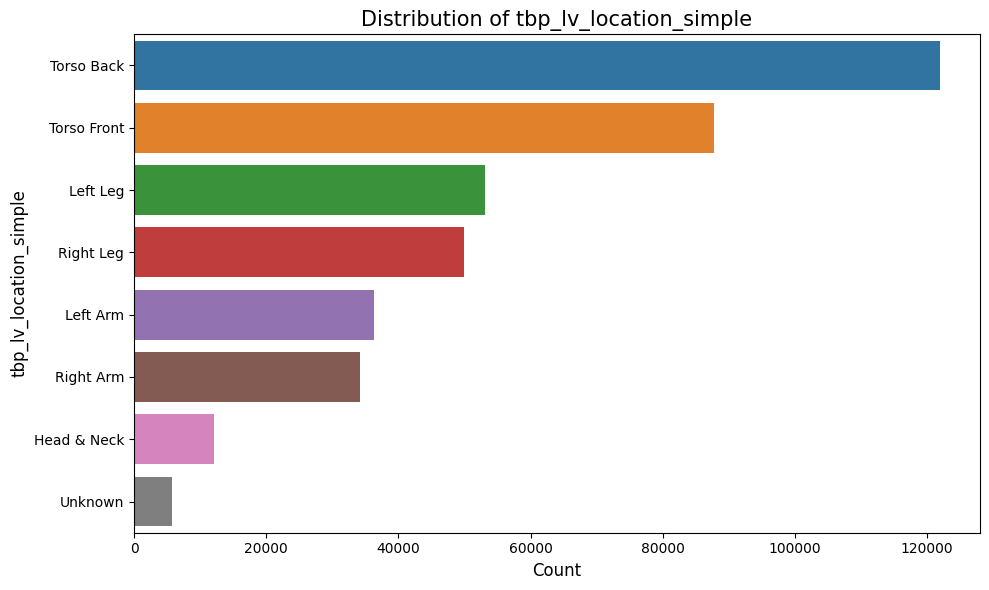


Unique values in attribution: 7
attribution
Memorial Sloan Kettering Cancer Center                                                                                                                 129068
Department of Dermatology, Hospital Clínic de Barcelona                                                                                                105724
University Hospital of Basel                                                                                                                            65218
Frazer Institute, The University of Queensland, Dermatology Research Centre                                                                             51768
ACEMID MIA                                                                                                                                              28665
ViDIR Group, Department of Dermatology, Medical University of Vienna                                                                                    12640
Departm

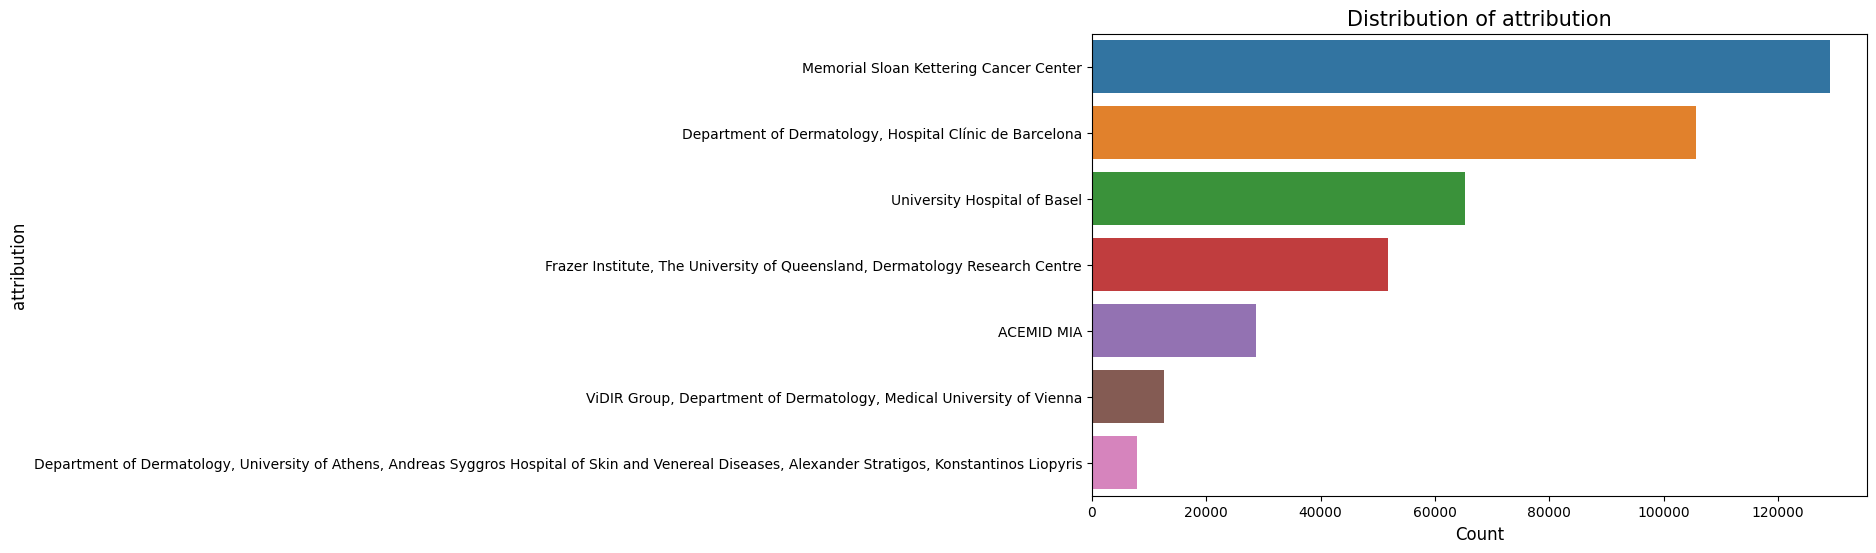


Unique values in copyright_license: 3
copyright_license
CC-BY       188812
CC-BY-NC    183582
CC-0         28665
Name: count, dtype: int64


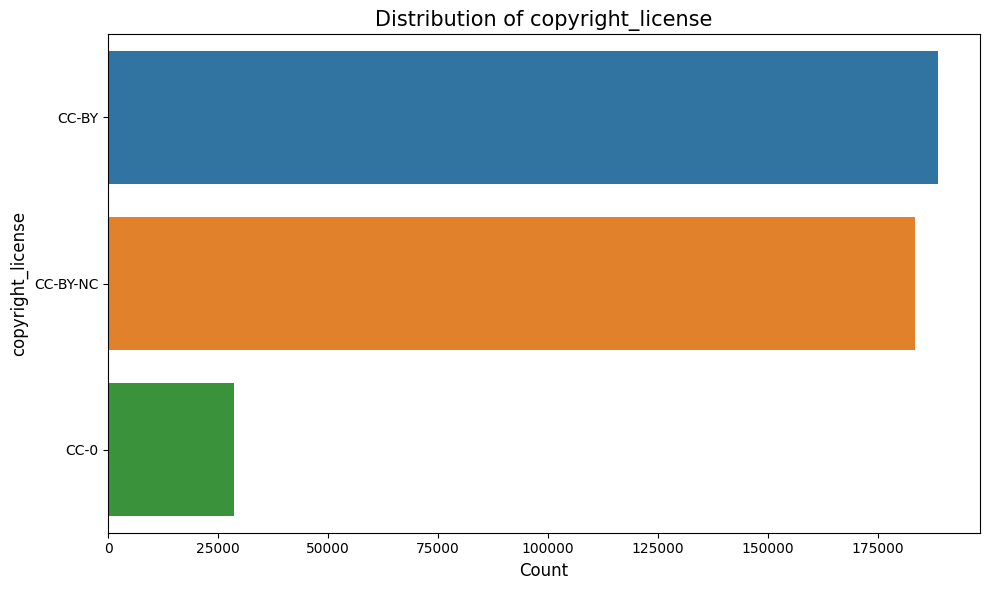

In [9]:
# 7. Inconsistent Data Analysis
print("\n--- Categorical Data Consistency Analysis ---")
categorical_cols = train_meta.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_cols:
    value_counts = train_meta[col].value_counts()
    unique_values = len(value_counts)
    
    print(f"\nUnique values in {col}: {unique_values}")
    
    if unique_values < 20:  # Only show if less than 20 unique values
        print(value_counts)
        
        # Visualize categorical distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(y=col, data=train_meta, order=value_counts.index[:20])
        plt.title(f'Distribution of {col}', fontsize=15)
        plt.xlabel('Count', fontsize=12)
        plt.ylabel(col, fontsize=12)
        plt.tight_layout()
        plt.savefig(f'categorical_dist_{col}.png')
        plt.show()
    else:
        print(f"Too many unique values ({unique_values}) to display. Top 10:")
        print(value_counts.head(10))


# Noise

In [10]:
print("\n--- Signal-to-Noise Ratio Analysis ---")
# For this analysis, we'll use coefficient of variation (CV) as a proxy for noise
cv_summary = pd.DataFrame(columns=['Column', 'CV'])

for col in numeric_cols_no_target:
    if train_meta[col].std() > 0 and train_meta[col].mean() != 0:  
        cv = train_meta[col].std() / abs(train_meta[col].mean())
        
        cv_summary = pd.concat([cv_summary, pd.DataFrame({
            'Column': [col],
            'CV': [cv]
        })])

print("\nFeatures with High Coefficient of Variation (Potential Noise):")
print(cv_summary.sort_values('CV', ascending=False).head(20))


--- Signal-to-Noise Ratio Analysis ---

Features with High Coefficient of Variation (Potential Noise):
                        Column         CV
0                     tbp_lv_x  63.799086
0                tbp_lv_deltaB   1.618971
0                     tbp_lv_z   1.575831
0               tbp_lv_areaMM2   1.133412
0       tbp_lv_nevi_confidence   1.076860
0  tbp_lv_radial_color_std_max   0.722736
0        tbp_lv_color_std_mean   0.712735
0            tbp_lv_norm_color   0.661411
0                  tbp_lv_stdL   0.640163
0      tbp_lv_symm_2axis_angle   0.608806
0                tbp_lv_deltaA   0.522859
0           tbp_lv_norm_border   0.499651
0           tbp_lv_perimeterMM   0.498304
0           tbp_lv_minorAxisMM   0.461919
0       clin_size_long_diam_mm   0.443436
0            tbp_lv_symm_2axis   0.407524
0                     tbp_lv_y   0.394210
0                tbp_lv_deltaL   0.388725
0               tbp_lv_deltaLB   0.366623
0           tbp_lv_deltaLBnorm   0.319005
